Implement the modularity detection algorithm on this artificial graph (adj matrix written in sparse format : each row is an edge [node_id, node_id, 1]). You will need to compute the modularity matrix B and its highest-val eigenvector V1. The split vector S (+1 / -1) aligns by sign with V1; follow this paper. Partition the graph in two parts K=2).
Optional: Partition the graph in more than 2 parts, try to figure out what is a "natural" K here.

In [1]:
import os
import requests
import numpy as np

URL = "https://www.ccs.neu.edu/home/vip/teach/DMcourse/6_graph_analysis/HW6/sparse_adj.txt"
LOCAL_FILE = "sparse_adj.txt"
if not os.path.exists(LOCAL_FILE):
    print("Downloading adjacency file...")
    r = requests.get(URL)
    r.raise_for_status()
    with open(LOCAL_FILE, "wb") as f:
        f.write(r.content)
    print("Download complete.\n")


Create Graph

In [2]:
edges = np.loadtxt(LOCAL_FILE, dtype=int, delimiter=',')
nodes = np.unique(edges[:, :2])
print(f"Found {len(nodes)} unique nodes and {len(edges)} edges.\n")

# node_id mapping (0 ~ n-1)
id_map = {node: idx for idx, node in enumerate(nodes)}
n = len(nodes)

Found 750 unique nodes and 113094 edges.



Build Matrix A

In [3]:
A = np.zeros((n, n), dtype=float)
for u, v, _ in edges:
    i, j = id_map[u], id_map[v]
    A[i, j] = 1
    A[j, i] = 1

Build Modularity Matrix B

In [4]:
# degree k, num of edge m
k = A.sum(axis=1)
m = k.sum() / 2
print(f"Total edges (m): {m:.1f}\n")

Kmat = np.outer(k, k) / (2 * m)
B = A - Kmat

Total edges (m): 56547.0



Eigen Vector, and Eigen values. And make the split vector.

In [5]:
eigvals, eigvecs = np.linalg.eigh(B)        
v1 = eigvecs[:, -1]  # most significant eigenvector
print(f"Eigenvector (v1): {v1}\n")

Eigenvector (v1): [-0.04822537 -0.04929216 -0.04414618 -0.04622561 -0.04813071 -0.04769948
 -0.0463001  -0.04723032 -0.0447117  -0.05245077 -0.05208188 -0.04695242
 -0.0500713  -0.04572923 -0.04647843 -0.05091447 -0.05075285 -0.05272747
 -0.04956583 -0.04859406 -0.04721315 -0.05041853 -0.04856297 -0.0504251
 -0.04812419 -0.05357588 -0.04635832 -0.05467638 -0.05346551 -0.05417297
 -0.04143963 -0.05055655 -0.05049506 -0.05032401 -0.05221964 -0.04603408
 -0.05189428 -0.04808991 -0.05341945 -0.04825367 -0.05199157 -0.05381806
 -0.04879652 -0.04428263 -0.04655084 -0.05052102 -0.05075124 -0.04508058
 -0.04889146 -0.05055391 -0.05079753 -0.05491105 -0.04505737 -0.05086492
 -0.05035702 -0.04581474 -0.05324349 -0.05025232 -0.05120724 -0.04888397
 -0.04880733 -0.05265687 -0.04053286 -0.04525806 -0.05191722 -0.04703512
 -0.04989911 -0.0473413  -0.05169447 -0.04659165 -0.04987819 -0.05151773
 -0.04093727 -0.04814138 -0.04536565 -0.04685059 -0.04962485 -0.04982442
 -0.05209345 -0.0534065  -0.052607

In [6]:
# split vector
S = np.where(v1 >= 0, 1, -1)

# community detection
community_pos = nodes[S == 1]
community_neg = nodes[S == -1]

print("Partition results (K=2):")
print(f" Community +1 (size {len(community_pos)}): {community_pos}")
print(f" Community -1 (size {len(community_neg)}): {community_neg}\n")


Partition results (K=2):
 Community +1 (size 430): [321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338
 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356
 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374
 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392
 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410
 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428
 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500
 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518
 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536
 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554


Calculate modularity Q

In [7]:
Q = (1 / (4 * m)) * S.dot(B.dot(S))
print(Q)

0.43817168697602316


plot the graph with Igraph.


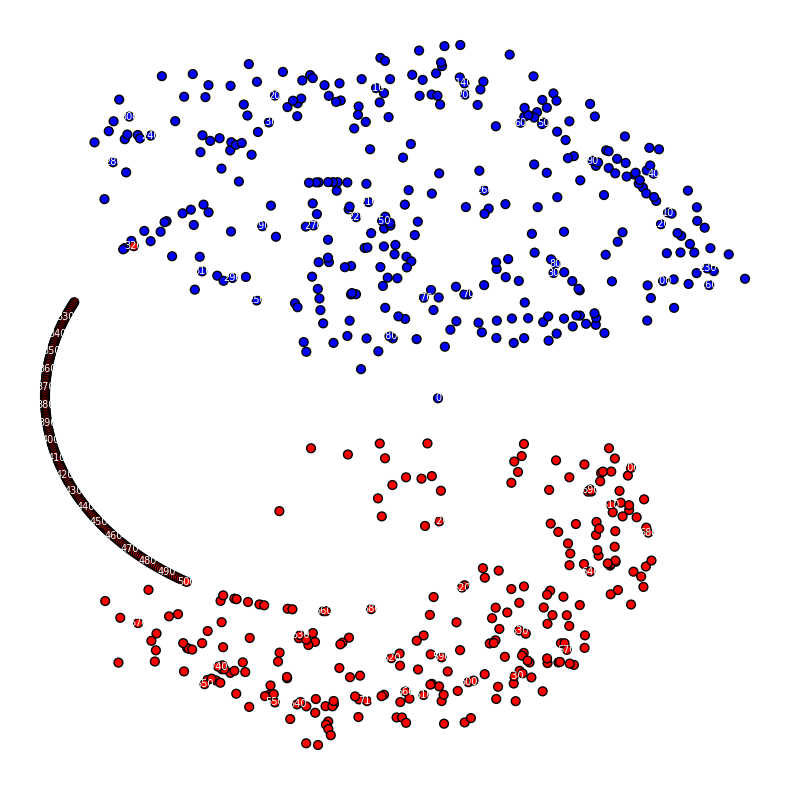

In [ ]:
import igraph as ig
import matplotlib.pyplot as plt

edges_list = [(int(u), int(v)) for u, v, _ in edges]

g = ig.Graph(edges_list)
layout = g.layout("kk")
all_coords = layout.coords   


n = len(S)
coords = all_coords[:n]

degree_dict = {i: d for i, d in enumerate(g.degree())}
filtered_edges = [(u, v) for u, v in g.get_edgelist()
                  if u < n and v < n and degree_dict[u] < 10 and degree_dict[v] < 10]

plt.figure(figsize=(8,8))
for u, v in filtered_edges:
    x0, y0 = coords[u]
    x1, y1 = coords[v]
    plt.plot([x0, x1], [y0, y1], color="gray", linewidth=1, alpha=0.1)

xs = [c[0] for c in coords]
ys = [c[1] for c in coords]
colors = ["red" if s == 1 else "blue" for s in S]

plt.scatter(xs, ys, c=colors, s=40, edgecolor="k")  # s=100 → s=40 정도로
for idx, (x, y) in enumerate(coords):
    if idx % 10 == 0:  # 10개마다 한 번씩만 표시
        plt.text(x, y, str(idx), ha="center", va="center", fontsize=7, color="white")

plt.axis("off")
plt.tight_layout()
plt.show()

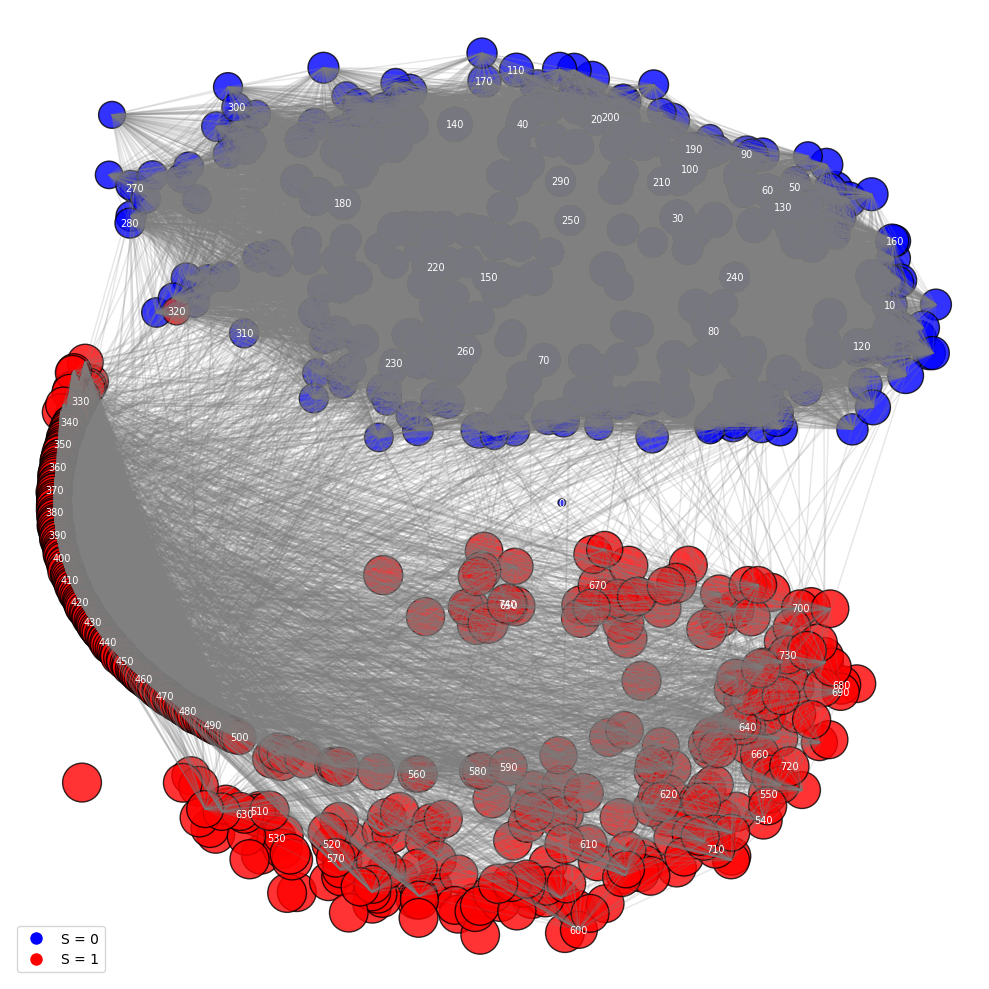

In [19]:
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# 1. 그래프 만들기
edges_list = [(int(u), int(v)) for u, v, _ in edges]
g = ig.Graph(edges_list)

# 2. 시각화할 노드 개수 n
n = len(S)

# 3. degree dict 만들기
degree_dict = {i: d for i, d in enumerate(g.degree())}

# 4. degree 기준 필터링 (상위 25% 제거)
degree_vals = np.array([degree_dict[i] for i in range(n)])
threshold = np.percentile(degree_vals, 75)
filtered_edges = [(u, v) for u, v in g.get_edgelist()
                  if u < n and v < n and degree_dict[u] < threshold and degree_dict[v] < threshold]

# 5. 서브그래프 생성 및 레이아웃
subgraph = g.induced_subgraph(list(range(n)))
layout = subgraph.layout("kk")
coords = layout.coords

# 6. 좌표 및 색상 설정
xs = [c[0] for c in coords]
ys = [c[1] for c in coords]
colors = ["red" if s == 1 else "blue" for s in S]
sizes = [30 + degree_dict[i]*2 for i in range(n)]  # degree 기반 크기

# 7. 시각화
plt.figure(figsize=(10, 10))

# 엣지 그리기
for u, v in filtered_edges:
    x0, y0 = coords[u]
    x1, y1 = coords[v]
    plt.plot([x0, x1], [y0, y1], color="gray", linewidth=1, alpha=0.1)

# 노드 그리기
plt.scatter(xs, ys, c=colors, s=sizes, edgecolor="k", alpha=0.8)

# 텍스트: 간헐적으로만 출력
for idx, (x, y) in enumerate(coords):
    if idx % 10 == 0:
        plt.text(x, y, str(idx), ha="center", va="center", fontsize=7, color="white")

# 범례 추가
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='S = 0', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='S = 1', markerfacecolor='red', markersize=10)
]
plt.legend(handles=legend_elements, loc='lower left')

plt.axis("off")
plt.tight_layout()
plt.show()